# EDA

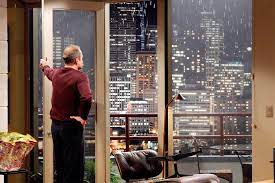

First, let's import all the libaries and other commands we might need.

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as plx


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Erin Robinson	Buyer	Invest in poor neighborhood, buying & selling, costs back + little profit, socially responsible

Investor chosen is Erin Robinson. This person seeks to invest into a poor neighborhood, buy and resell the houses with a little profit. Her approach is socially responsible, so it can be assumed she want to up former not renovated houses to improve the neighborhood as a whole. Therefore mainly houses in the lower quantil are to be considered. Prices that are low and will still be low when reselling. 



- find neighborhoods with low prices
    - houses in poor n will have bad graded and condition as there is no money for renovations
    - assumption 0 : the price of a house rises overproportionally to the squarefeet available
        - low squarefeet prices will indicate poor neighborhoods


    - need to consider here to filter for small lots as well, as big lots might be very rural
    filter by smaller than the median of lots
    - squarefeetliving15 will likely have similar values to sqftliving


    filter by sqftliving15 smaller than 1.5 times sqftliving
- a poor neighborhood will mainly consist of low prices, with bad grade and condition
    - assumption 1: poor = low price, low grade, low condition
- identify houses that have not been renovated
    - assumption 2: unrenovated houses will have lower prices than renovated ones

- additional bed, bathrooms, floors or waterfront are a plus, but not mandatory, will be ignored

- assumption 3: there is a correlation between zipcodes and prices

In [4]:
# reading in the dataset and exploring it a bit 

df = pd.read_csv("data/King_County_House_prices_dataset.csv")
df.shape
df.describe()
#df.info()  #

# date is not datetime, some columns seem to have missing values, 
#specially renovated, which is important to us but will be dealt with at a later point

#df['date'] = pd.to_datetime(df['date'])
#df.head()
#df.zipcode.unique()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,19221.000,21534.000,21597.000,21597.000,21597.000,21597.000,17755.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,4580474287.771,540296.574,3.373,2.116,2080.322,15099.409,1.494,0.008,0.234,3.410,7.658,1788.597,1971.000,83.637,98077.952,47.560,-122.214,1986.620,12758.284
std,2876735715.748,367368.140,0.926,0.769,918.106,41412.637,0.540,0.087,0.766,0.651,1.173,827.760,29.375,399.946,53.513,0.139,0.141,685.230,27274.442
min,1000102.000,78000.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123049175.000,322000.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,1951.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,1975.000,0.000,98065.000,47.572,-122.231,1840.000,7620.000
75%,7308900490.000,645000.000,4.000,2.500,2550.000,10685.000,2.000,0.000,0.000,4.000,8.000,2210.000,1997.000,0.000,98118.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,2015.000,2015.000,98199.000,47.778,-121.315,6210.000,871200.000


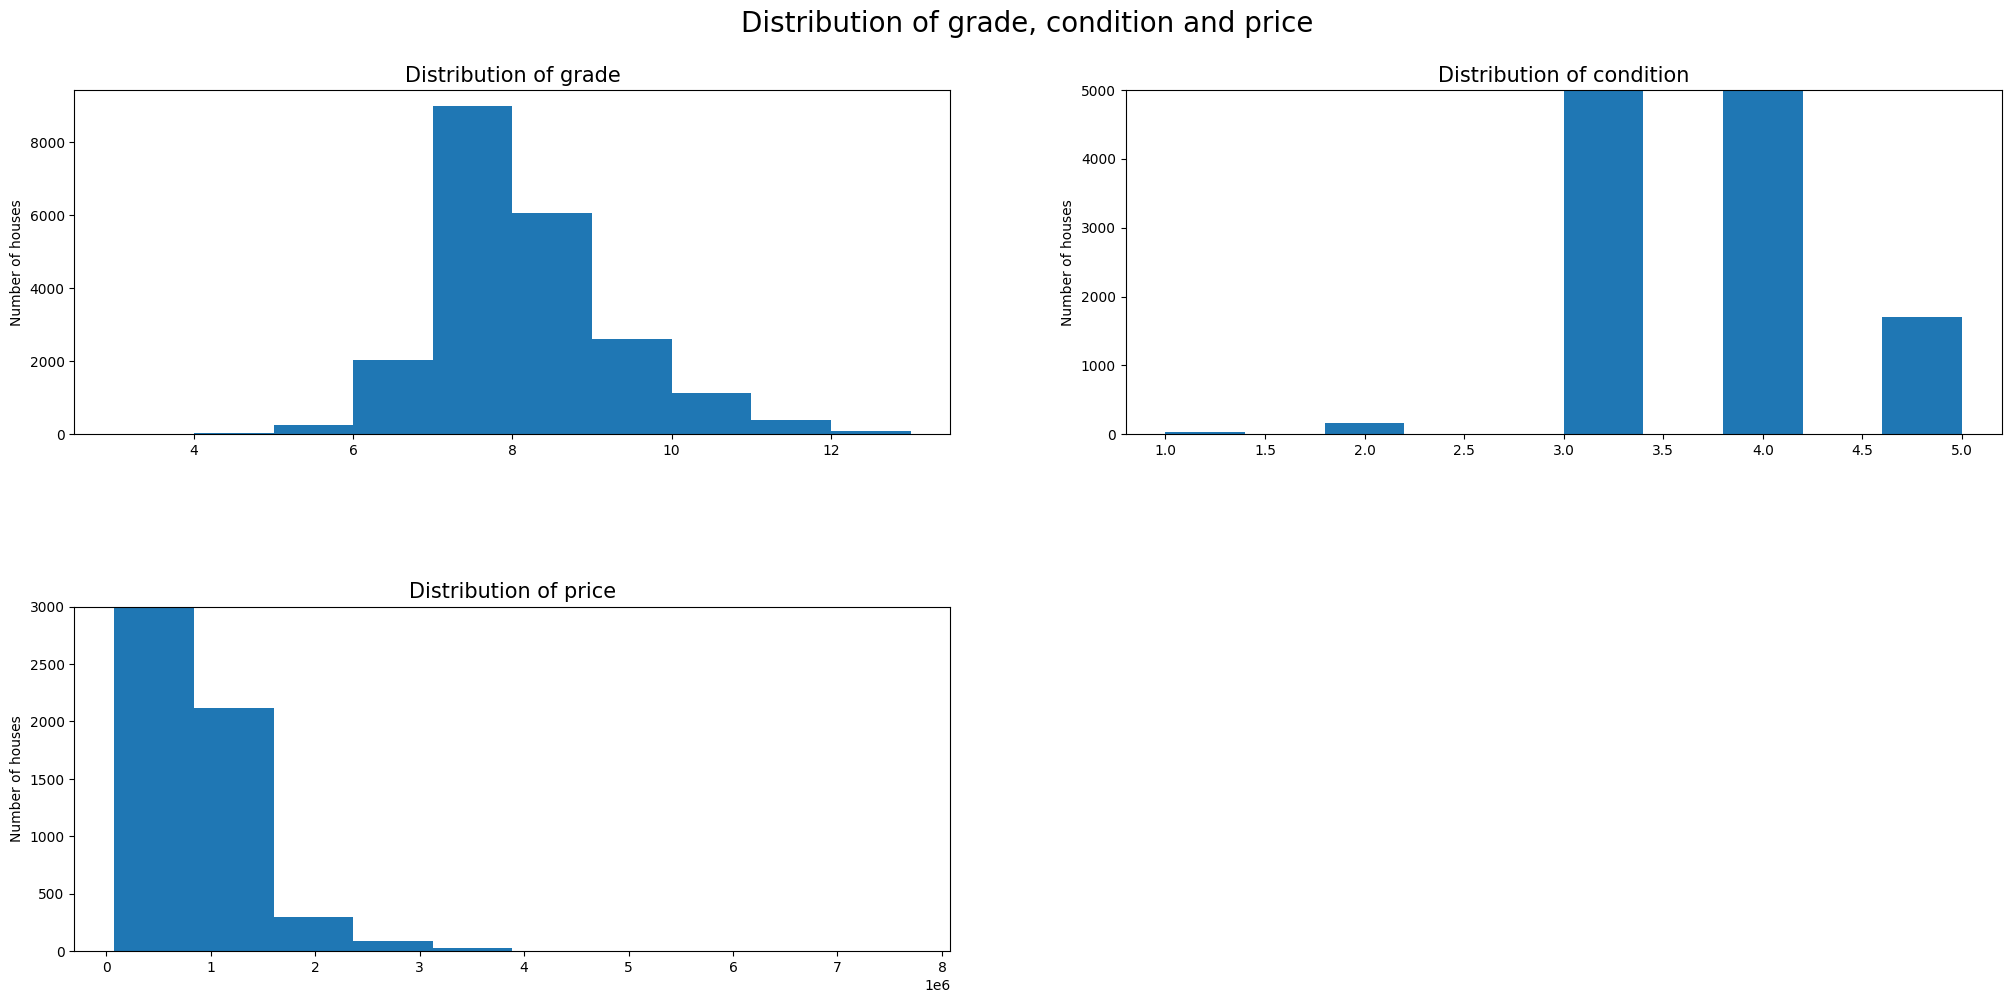

In [5]:
#describe shows we have some heavy outliers, lets check for the values that are interesting to us

fig, ax = plt.subplots(2,2, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of grade, condition and price', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

ax[0][0].hist(x = df["grade"]) # creates boxplot for number of views
ax[0][0].set_ylabel("Number of houses", fontsize = 10) # sets the label for the ticks on the x-axis
#ax[0][0].set_ylim(0,2000000) # limits the y-axis values from 0 to 2000000 
ax[0][0].set_title("Distribution of grade", fontsize = 15); # sets title for subplot

ax[0][1].hist(x = df['condition'])
ax[0][1].set_ylabel("Number of houses", fontsize = 10)
ax[0][1].set_ylim(0,5000)
ax[0][1].set_title("Distribution of condition", fontsize = 15);

ax[1][0].hist(x = df['price'])
ax[1][0].set_ylabel("Number of houses", fontsize = 10)
ax[1][0].set_ylim(0,3000)
ax[1][0].set_title("Distribution of price", fontsize = 15);

fig.delaxes(ax[1][1])

The majority of the houses seem to have an average grade and condition. Most prices are below 1m, only few hundred houses have higher prices than 2m

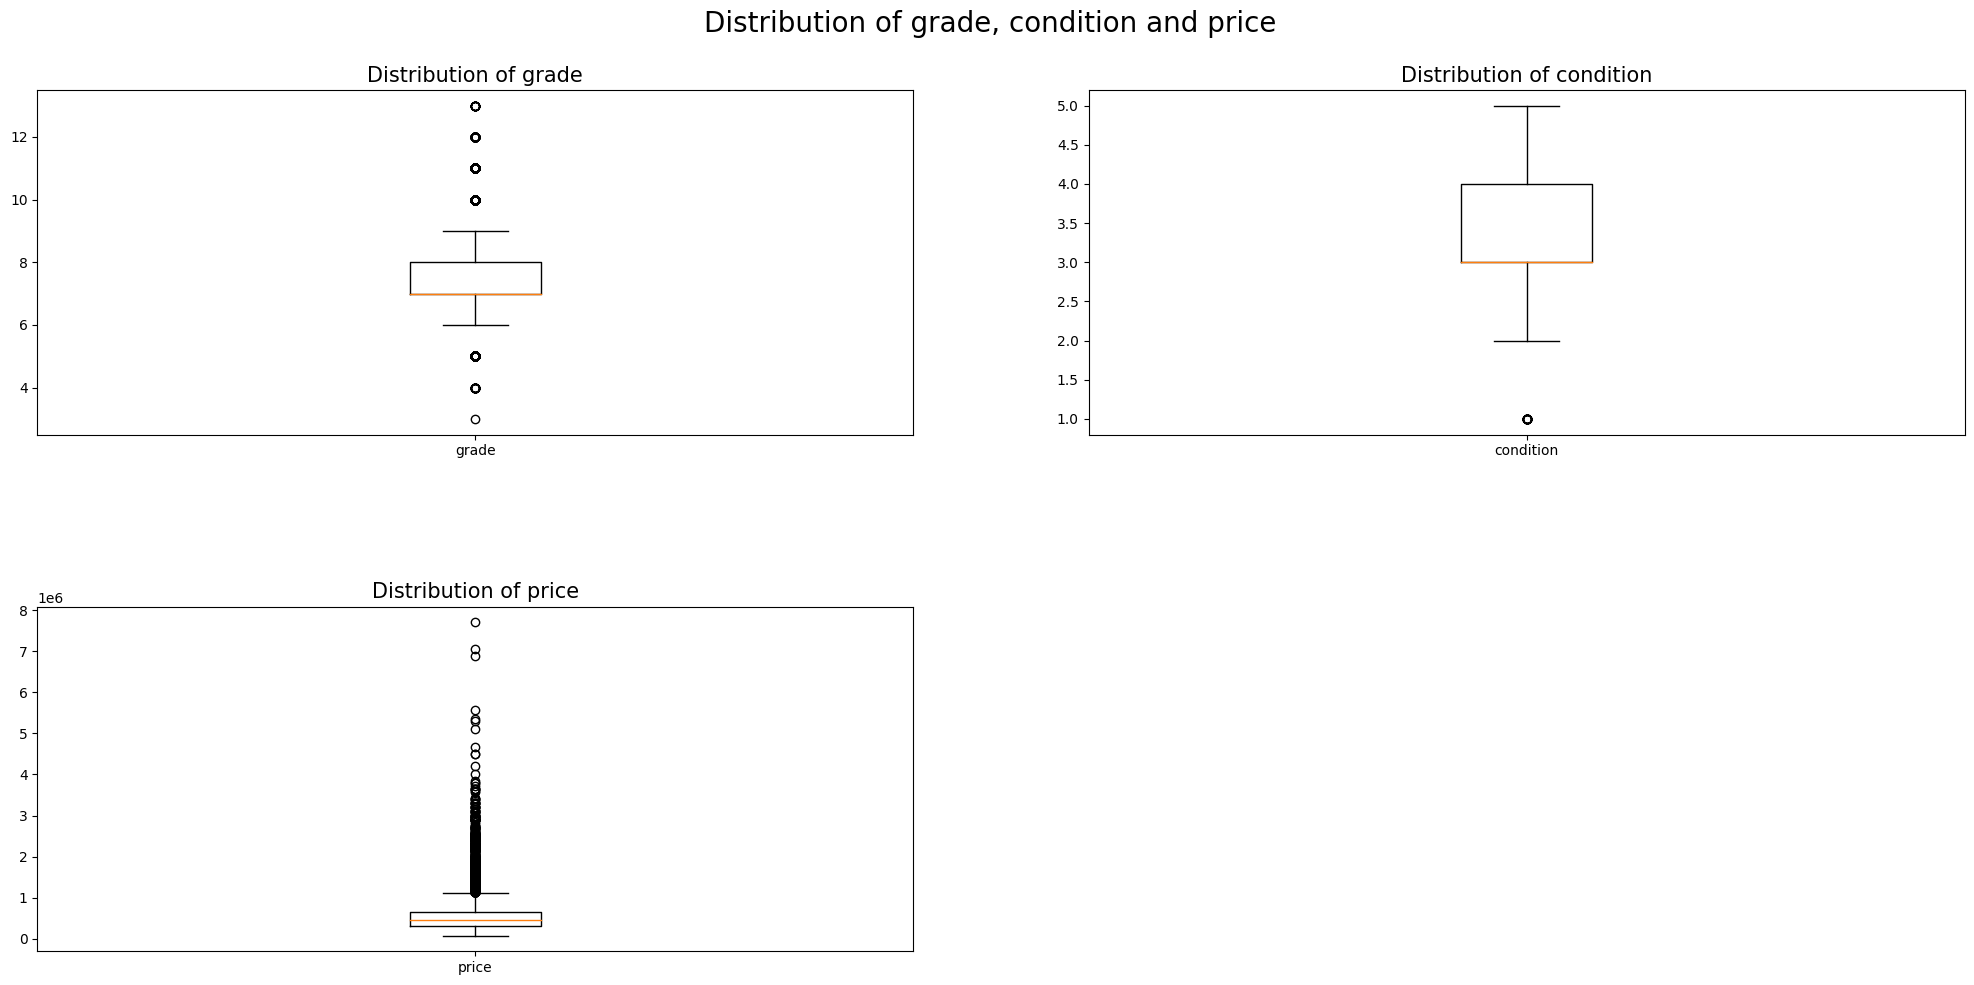

In [6]:
# for statistical purposes, lets build some boxplots to have a visual representation of the statistical data

fig, ax = plt.subplots(2,2, figsize=(20,10)) # create subplots on 2 rows and 3 columns
plt.suptitle('Distribution of grade, condition and price', fontsize=20)
fig.tight_layout() # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots

ax[0][0].boxplot(x = df["grade"]) # creates boxplot for number of views
ax[0][0].set_xticklabels(labels=["grade"]) # sets the label for the ticks on the x-axis
#ax[0][0].set_ylim(0,2000000) # limits the y-axis values from 0 to 2000000 
ax[0][0].set_title("Distribution of grade", fontsize = 15); # sets title for subplot

ax[0][1].boxplot(x = df['condition'])
ax[0][1].set_xticklabels(labels=["condition"])
#ax[0][1].set_ylim(0,50000)
ax[0][1].set_title("Distribution of condition", fontsize = 15);

ax[1][0].boxplot(x = df['price'])
ax[1][0].set_xticklabels(labels=["price"])
#ax[0][2].set_ylim(0,6000)
ax[1][0].set_title("Distribution of price", fontsize = 15);

fig.delaxes(ax[1][1])

First hypothesis is that the house price rising overproportionally to the available living space in the house

So, for the first hypothesis we plot the house price in relation to the available living space and add the grade as third dimension by colour

Text(0, 0.5, 'Square feet available for living')

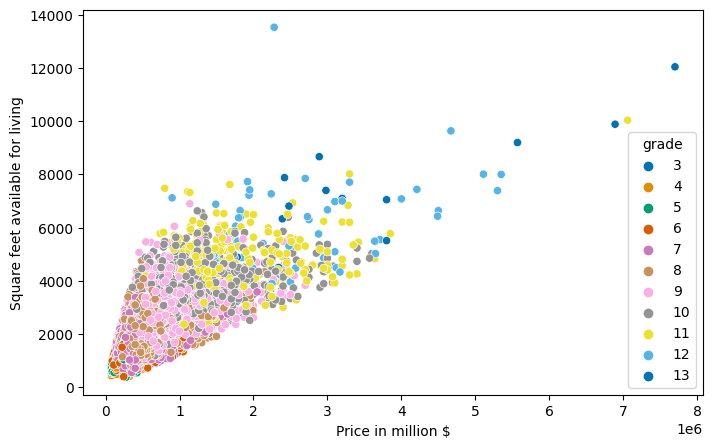

In [21]:
# House price in comparison to available living space, with grade added

psg = sns.scatterplot(x=df['price'], y=df['sqft_living'], hue=df.grade, palette = "colorblind")
psg.set_xlabel("Price in million $")
psg.set_ylabel("Square feet available for living")


# general tendency of growing living space with growing price, while the grade also has influence on price
# > with low price usually comes with small living space and low grade

Text(0.5, 0, 'Price in million $')

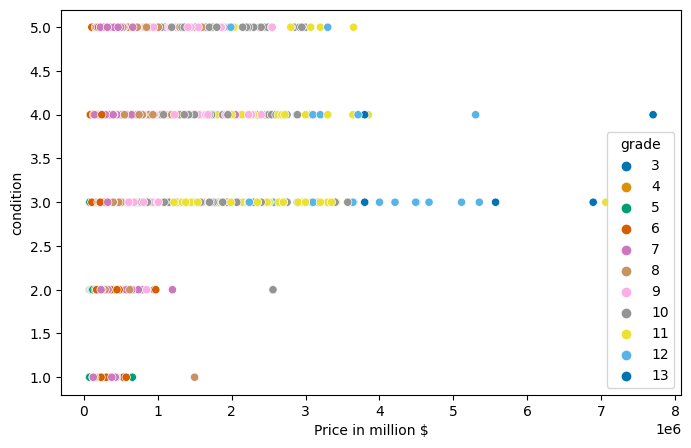

In [22]:
# plotting price in relation to condition, with grade added as third dimension in colour

plo1 = sns.scatterplot(x=df['price'], y=df['condition'], hue=df['grade'], palette="colorblind")
#ax.set_xlabel("Price in million $")
plo1.set_xlabel("Price in million $")

# plot is heavily skwed to the right, checking for amount of houses with a price > 1.000.000

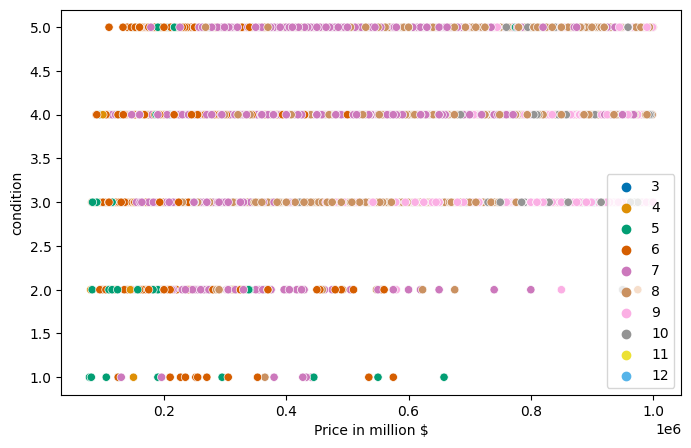

In [27]:
dfscat = df.copy()
# dfscat = df[df['price'] > 1000000] ## 1458 rows with houses over 1M, filtering these out
dfscat = df[df['price'] < 1000000]
dfscat.name = "fprice"
#dfscat

plo2 =sns.scatterplot(x=dfscat['price'], y=dfscat['condition'], hue=dfscat['grade'], palette = "colorblind")
plo2.set_xlabel("Price in million $")
plo2.legend(loc ='lower right')

#plt.show()

#plot shows a tendency of higher grade houses to be in the higher price range, 
#as well as a tendency of higher condition with higher price

# > stakeholder should search for houses with low price and lower conditions + grade
# improving the house by renovating will likely raise grade and should improve condition ranking

renovated houses have higher grades then unrenovated houses

In [10]:
df.yr_renovated # either has year of renovation or an NaN/zero if never renovated
#df.condition.unique() # condition has values from 1-5
#df.waterfront.unique() # yes, no, not available
#df.floors.unique() # apparently floor ranges from 1-3.5
#df.grade.unique() #grade from 3 to 13

df2= df.copy()
df2[df2.yr_renovated.isnull()]

df2['yr_renovated'] = df2.yr_renovated.replace(np.NaN,0) # replacing empty values with zero

#according to different websites it is suggested to renovate a house every 15-20 years. Thus we will consider any house built in the last 20 years renovated as well. Let's define a new metric for this
df2['renovated'] = (df['yr_built'] > 1995) | (df['yr_renovated'] > 1995)
#df2['renovated'].value_counts()


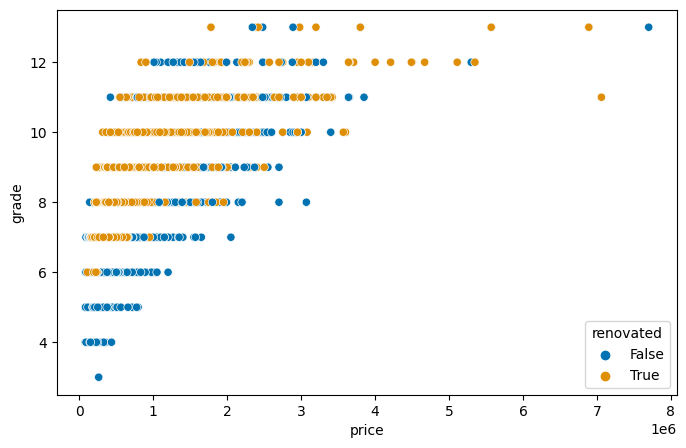

503954.52046595444 633493.936128074
7.395868194104775 8.329922429443803
1.2570458452130717
129539.41566211951
0.934054235339028
1.1262940618768138


In [28]:
# plot the grade based on the note and colour it whether it is a renovated property or not
#further print the average values for price, grade and also give the difference between them

sns.scatterplot(x=df2['price'], y=df2['grade'],hue=df2['renovated'], palette = "colorblind")

plt.show()
print(df2.query('renovated == False').price.mean(), df2.query('renovated == True').price.mean())
print(df2.query('renovated == False').grade.mean(), df2.query('renovated == True').grade.mean())

print((df2.query('renovated == True').price.mean())/(df2.query('renovated == False').price.mean()))
print((df2.query('renovated == True').price.mean())-(df2.query('renovated == False').price.mean()))

print((df2.query('renovated == True').grade.mean())-(df2.query('renovated == False').grade.mean()))
print((df2.query('renovated == True').grade.mean())/(df2.query('renovated == False').grade.mean()))

Yes, both price of renovated houses and grade are significantly higher. 

In [12]:
#define price per sqft by dividing price by the sqft_living value
# then place these into 10 bins and add to a new dataframe
df2['price_sqr_living']= (df2['price'] / df2['sqft_living'])
df2_bins=pd.cut(df2['price_sqr_living'],10,labels=[1,2,3,4,5,6,7,8,9,10])
df2_bins.name='sqt_price_bins'
df2_join = df2.join(df2_bins)

#group by the zipcode and calculate the average for the price per sqft for living space, display them sorted by price in ascending order
df3 = df2.groupby(['zipcode']).mean()['price_sqr_living'].reset_index()
df3.sort_values('price_sqr_living').head(10)

,zipcode,price_sqr_living
13,98023,148.922
1,98002,151.174
0,98001,151.348
20,98032,154.220
18,98030,155.156
40,98092,155.814
2,98003,157.113
19,98031,161.102
26,98042,164.378
67,98188,169.007


<AxesSubplot:xlabel='zipcode', ylabel='price_sqr_living'>

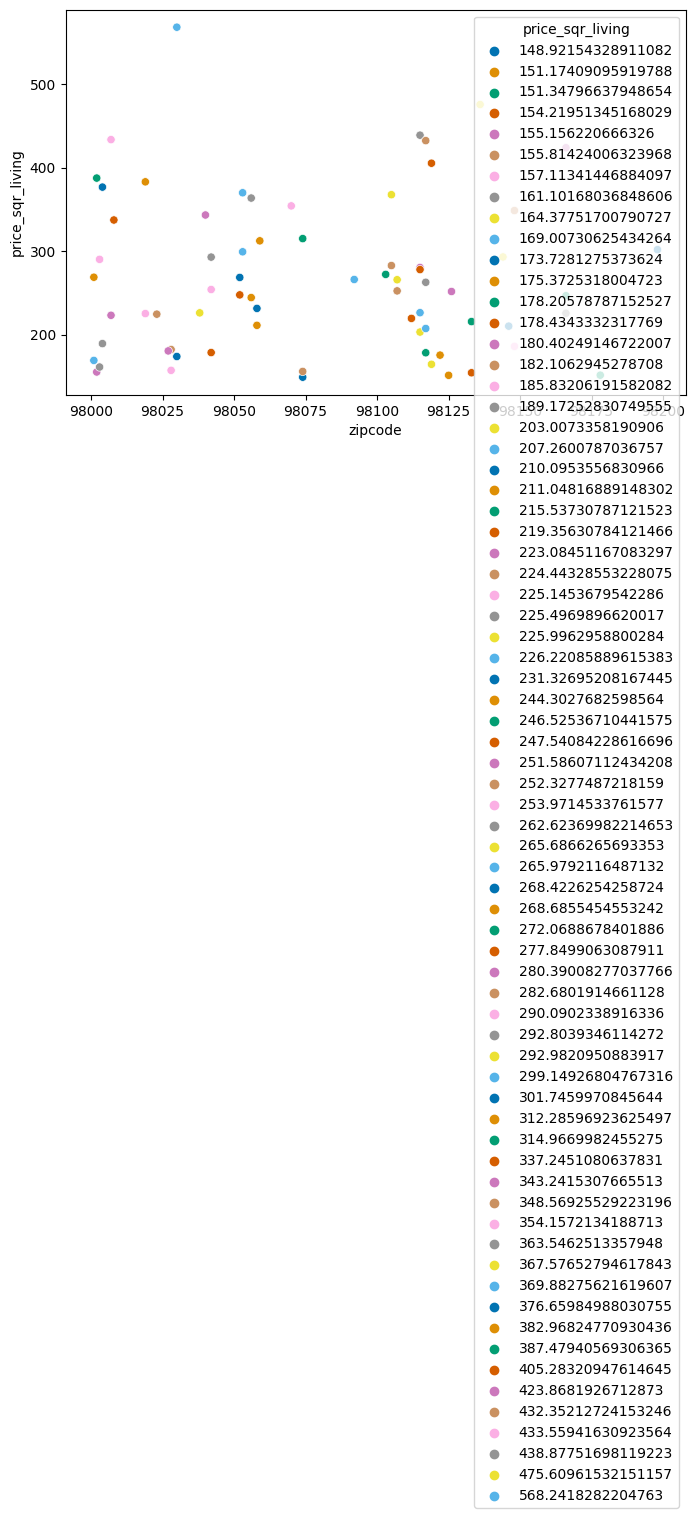

In [29]:
#plot values grouped above visually
sns.scatterplot(x=df2['zipcode'], y= df3['price_sqr_living'], hue=df3['price_sqr_living'], palette="colorblind")

In [14]:
fig = plx.density_mapbox(df2, lat='lat', lon='long', z='price', radius=10,
                        center=dict(lat=df.lat.mean(), lon=df.long.mean()), zoom=8,
                        mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [15]:
fig = plx.density_mapbox(df, lat='lat', lon='long', z='grade', radius=10,
                        center=dict(lat=df.lat.mean(), lon=df.long.mean()), zoom=8,
                        mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [16]:
#df2['price_sqr_living']= df2['price'] / df2['sqft_living']


#fig = plx.density_mapbox(df2, lat='lat', lon='long', z='price_sqr_living', radius=10,
#                        center=dict(lat=0, lon=180), zoom=0,
#                        mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

In [17]:


fig = plx.density_mapbox(df2_join[df2_join['sqt_price_bins'] == 1], lat='lat', lon='long', z='price_sqr_living', radius=10,
                       zoom=8,
                      mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



In [18]:
fig = plx.density_mapbox((df2_join[(df2_join['sqt_price_bins'] == 1) & (df2_join['renovated'] == False)]), lat='lat', lon='long', z='price_sqr_living', radius=10,
                        zoom=8,
                      mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [33]:
# rounding of price_sqft_living to 2 decimals
# displaying the smallest bin(10%) of price_sqr_living & unrenovated houses, while displaying their grade through colour

df2_join['price_sqr_living']=round(df2_join.price_sqr_living, 2)
fig = plx.scatter_mapbox((df2_join[(df2_join['sqt_price_bins'] == 1) & (df2_join['renovated'] == False)]), lat="lat", lon="long", hover_data=['price_sqr_living', 'zipcode'],
                        color="grade",color_continuous_scale= "thermal", zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0}) # sets the margin from the left, top, right and bottom order
fig.update_layout(title_text='Houses in the lower range of price/sqft ', title_x=0.5) # sets a title for the plot and centers it
fig.show()